In [1]:
import os

# Set datapath properly
path = os.getcwd() + "/data/"

if not os.path.exists(path):
  os.makedirs(path)

%env DATAPATH={path}

raw = 's.rsf'
raw_hfile = 's_hfile.rsf'
raw_tfile = 's_tfile.txt'
raw_bfile = 's_bfile.txt'
raw_deghost = "s_deghost.rsf"
raw_deghost_cdp = 's_deghost_cdp.rsf'
raw_deghost_gain = "s_deghost_gain.rsf"
raw_deghost_gain_cdp = "s_deghost_gain_cdp.rsf"
vnmo_rsf = 'vnmo.rsf'
vnmow_rsf = 'vnmow.rsf'
sample = 'sample.rsf'
sample_deghost = 'sample_deghost.rsf'
sample_deghost_gain = 'sample_deghost_gain.rsf'
header_complete = 'sp_header_complete.rsf'
header_complete_int = 'sp_header_complete_int.rsf'
offsets = 'offsets.rsf'
cdp_offsets = 'cdp_offsets.rsf'
sample_offsets = 'sample_cdp_offsets.rsf'
cdp_mask = "cdp_mask.rsf"
wavelet_file = os.getcwd() + "/../FarField.dat"

import numpy as np
import pandas as pd
from rsf.proj import *
import rsf.api as sf
import m8r
from m8r import view
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import periodogram, welch
from wiggle.wiggle import wiggle
import matplotlib
import matplotlib.PythonPlot as plt
from scipy.interpolate import griddata
from scipy.interpolate import Rbf

env: DATAPATH=/home/kerim/Documents/JUDI.jl/examples/field_examples/viking_graben_line12/proc/data/


Extract CDP sample

In [2]:
sample_deghost_gain_cdp = 'sample_deghost_gain_cdp.rsf'

cdp = 1000
!sfwindow f3={cdp} n3=1 < {raw_deghost_gain_cdp} > {sample_deghost_gain_cdp}
!sfintbin < {header_complete} head={header_complete_int} yk=cdp xk=cdpt | \
    sfwindow f3={cdp} n3=1 | \
    sfheadermath output='offset'/1000. > {sample_offsets}

sfintbin: 2142 of 2142;


Compare mute

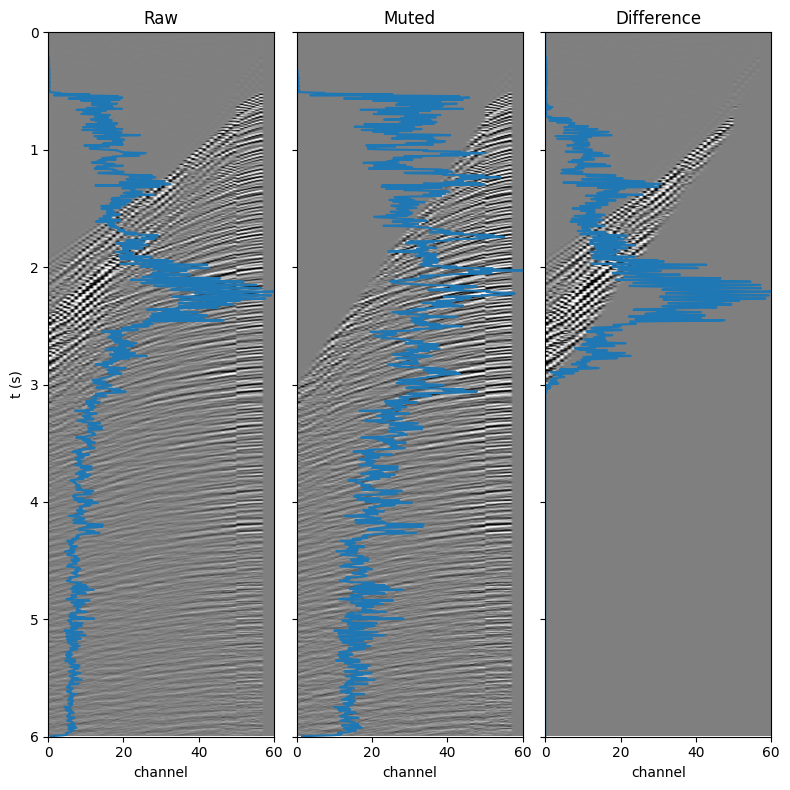

In [3]:
sample_deghost_gain_mute_cdp = 'sample_receiver_deghost_gain_mute_cdp.rsf'
raw = sample_deghost_gain_cdp
proc = sample_deghost_gain_mute_cdp

# process
t0=0
v0=1.1
!sfmutter < {raw} offset={sample_offsets} half=n t0={t0} v0={v0} > {proc}

# Load shot and visualize it
raw_in = sf.Input(raw)
d1 = raw_in.float('d1')

raw_arr = np.array(raw_in)
proc_arr = np.array(sf.Input(proc))

titles = ["Raw", "Muted", "Difference"]
t = np.arange(raw_arr.shape[1]) * d1
plt.figure(figsize=(8,8))
for i, data in enumerate([raw_arr, proc_arr, raw_arr-proc_arr]):
    plt.subplot(1,3, i+1)
    perc = np.percentile(data.ravel(), 99)
    extent = [0, data.shape[0], t[-1], t[0]]
    plt.imshow(data.clip(-perc, perc).T, aspect='auto', extent=extent,
              cmap='gray_r')
    rms = np.sqrt(np.mean(data**2, axis=0))
    coef = data.shape[0]/(rms.max()-rms.min())
    rms_normilized = (rms-rms.min())*coef
    plt.plot(rms_normilized, t)
    if i == 0:
        plt.ylabel('t (s)')
    plt.xlabel('channel')
    plt.title(titles[i])
    plt.ylim(6,0)

for ax in plt.gcf().axes:
    try:
        ax.label_outer()
    except:
        pass
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)

Apply the processing to the whole dataset

In [4]:
raw_deghost_gain_mute = "s_deghost_gain_mute.rsf"
raw_deghost_gain_mute_cdp = "s_deghost_gain_mute_cdp.rsf"

raw = raw_deghost_gain
proc = raw_deghost_gain_mute
proc_cdp = raw_deghost_gain_mute_cdp

!sfmutter < {raw} offset={offsets} half=n t0={t0} v0={v0} > {proc}
!sfintbin < {proc} yk=cdp xk=cdpt head={header_complete_int} > {proc_cdp}

sfintbin: 2142 of 2142;


Compare stacks

sfnmo: CMP 2142 of 2142;
sfnmo: CMP 2142 of 2142;


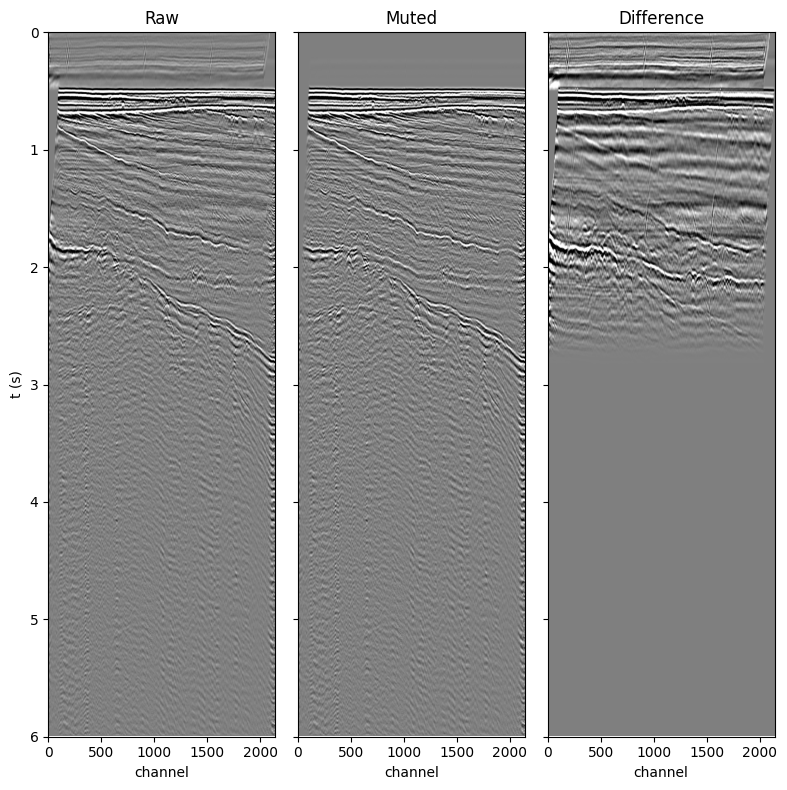

In [5]:
raw = raw_deghost_gain_cdp
proc = raw_deghost_gain_mute_cdp

raw_stack = 's_deghost_gain_cdp_stk.rsf'
proc_stack = 's_deghost_gain_mute_cdp_stk.rsf'

!sfnmo < {raw} velocity={vnmo_rsf} offset={cdp_offsets} half=n | \
    sfstack > {raw_stack}

!sfnmo < {proc} velocity={vnmo_rsf} offset={cdp_offsets} half=n | \
    sfstack > {proc_stack}

# Load stacks and visualize it
raw_stack_in = sf.Input(raw_stack)
proc_stack_in = sf.Input(proc_stack)

raw_stack_arr = np.array(raw_stack_in)
proc_stack__arr = np.array(proc_stack_in)

plt.figure(figsize=(8, 8))
for i, data in enumerate([raw_stack_arr, proc_stack__arr, raw_stack_arr-proc_stack__arr]):
    plt.subplot(1,3, i+1)
    perc = np.percentile(data.ravel(), 99)
    extent = [0, data.shape[0], t[-1], t[0]]
    plt.imshow(data.clip(-perc, perc).T, aspect='auto', extent=extent,
              cmap='gray_r')
    if i == 0:
        plt.ylabel('t (s)')
    plt.xlabel('channel')
    plt.title(titles[i])
    plt.ylim(6,0)

for ax in plt.gcf().axes:
    try:
        ax.label_outer()
    except:
        pass
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)